In this notebook, I will explain the algorithms I used in this project. To read the information in the card, I need multiple steps including cropping the card part in the image, localizing the text areas and read the texts. Different steps require different techniques. In addition, the techniques needed to process the backside is different from those for the frontside, so I will explain them separately.

# Frontside

## Align the image

We start with an image of the ID card. The image is captured by a camera, not a scanner, so the ID card does not fit exactly in the frame. The area near the boundary of the image is usually the background behind the card. In this step, we will remove the background and get an image with the card fitted exactly.

Text(0.5, 1.0, 'Original image')

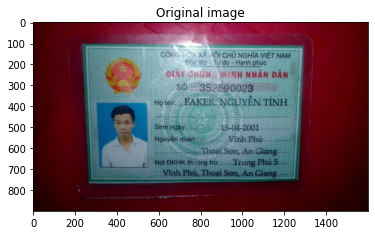

In [3]:
import cv2
import matplotlib.pyplot as plt
from alignment_frontside import align_card

img = cv2.imread('data/cmnd1.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Original image')

Text(0.5, 1.0, 'Expected image')

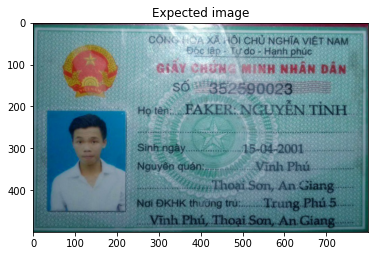

In [4]:
img_aligned = align_card(img)
plt.imshow(img_aligned)
plt.title('Expected image')

The image is usually captured not from the right angle to the plane containing the card, so the area containing the card in the image is a usual quadrilateral, not a rectangle like its actual shape. Therefore, to recover it to the expected form as above, we need to find its 4 corners and use the perspective transform to transform it into the expected form.

If we apply corner detection algorithms directly to the original image, we will be flooded with a lot of corners found in the image and may not be able to identify the 4 corners among them. Therefore, I used a different approach. First, I tried to segment the area in the image belonging to the ID card. To do this, I choose from the image the pixels having the color green. Using HSV color space, this can be done by thresholding the values on the 3 channels.

Notice that this will only work if **the background is not green**. I think this is a reasonable assumption since the background are usually tables, ground, walls or hands which are not usually colored green.

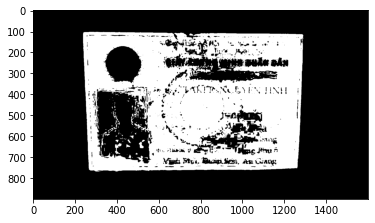

In [5]:
import numpy as np
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = np.logical_and(hsv[:,:,0] >= 40, hsv[:,:,0] < 100)
# Remove the black and white area where hue might accidentally fall into the range
mask = np.logical_and(mask, hsv[:,:,1] >= 20)
mask = np.logical_and(mask, hsv[:,:,2] >= 20)
mask = (mask * 255).astype('uint8')
plt.imshow(mask, cmap='gray')

Here we see that the card is segmented with some noise since there are some spots on the card whose color is not green. We can fill those spots with the closing transform, one of morphological transforms applied for binary images, to reduce the noise and make our segmentation mask smoother.

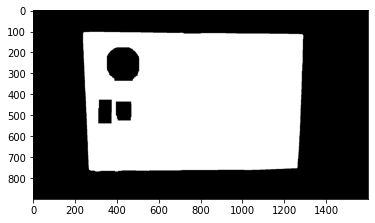

In [6]:
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,
                        cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)),
                        iterations=30)
plt.imshow(mask, cmap='gray')

From this mask, I will find the 4 lines corresponding to the 4 sides of the card, then the 4 corners are just the intersections of those lines. Before finding the lines, we need to get the points lying on the sides from the mask above by finding the contour around the masked area.

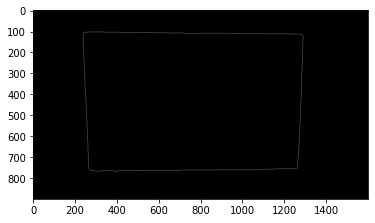

In [7]:
contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
boundaries = np.zeros_like(mask, dtype='uint8')
cv2.drawContours(boundaries, contours, -1, 255)
plt.imshow(boundaries, cmap='gray')

Next, we use the Hough line transform to find the lines that go through the points above. In this algorithm, each line is represented by the equation $x\cos\theta + y\sin\theta = r$ where $(r, \theta)$ are the parameters. The algorithm in opencv returns a list of pairs $(r, \theta)$ whose corresponding line passes through a thresholded number of points, ordered by number of points they pass through. Hence, usually more than 4 lines are returned, so we need find the 4 that best match our need and identify exactly which of the 4 sides they are.

We can identify that using the values of $r$ and $\theta$. In order for the code below to run properly, **the card is required to not be rotated more than 45 degree from the expected pose**.

Some of the parameters in the code are fixed, which makes it specialized to a particular scale, so all images should be resize to a fixed scale before going through this pipeline. In my code, I resize all images to have 1000 pixels wide.

In [8]:
# Use Hough transform to find the lines fitted to the contour points
lines = cv2.HoughLines(boundaries, 10, np.pi/60, 100)
lines = lines.reshape(-1, 2)

# Categorize horizontal vs vertical line based on theta
hlines = []
vlines = []
for line in lines:
    if np.pi/4 <= line[1] <= 3*np.pi/4:
        hlines.append(line)
    else:
        vlines.append(line)
hlines = np.array(hlines)
vlines = np.array(vlines)

# Categorize top-bottom and left-right based on rho
htop = None
hbottom = None
for hline in hlines:
    if hline[0] < np.mean(hlines, axis=0)[0]:
        if htop is None:
            htop = hline
    else:
        if hbottom is None:
            hbottom = hline

vleft = None
vright = None
for vline in vlines:
    if abs(vline[0]) < np.mean(np.abs(vlines), axis=0)[0]:
        if vleft is None:
            vleft = vline
    else:
        if vright is None:
            vright = vline
            
htop, hbottom, vleft, vright

(array([105.       ,   1.5707964], dtype=float32),
 array([755.       ,   1.5707964], dtype=float32),
 array([-235.      ,    3.089233], dtype=float32),
 array([1.295000e+03, 5.235988e-02], dtype=float32))

Now with the lines indentified, we can get the intersections easily by solving the intersection equation of the corresponding lines. Finally, with the 4 corners, we can find and apply the perspective transformation to warp it into the expected form.

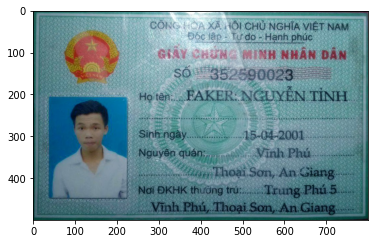

In [9]:
def find_intersect(hline, vline):
    A = np.array([[np.cos(hline[1]), np.sin(hline[1])], [np.cos(vline[1]), np.sin(vline[1])]])
    b = np.array([hline[0], vline[0]])
    return np.linalg.solve(A, b)

topleft = find_intersect(htop, vleft)
topright = find_intersect(htop, vright)
bottomleft = find_intersect(hbottom, vleft)
bottomright = find_intersect(hbottom, vright)

target_dsize = (800, 500)
keypoints = np.array([topleft, topright, bottomleft, bottomright])
w, h = target_dsize
targets = np.array([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]], dtype='float32')
M = cv2.getPerspectiveTransform(keypoints, targets)
img_warped = cv2.warpPerspective(img, M, target_dsize)
plt.imshow(img_warped)

## Text localization and reading

After accquiring the image aligned exactly in the picture as above, we proceed to read the information from the text. To read the text, we need an OCR model. We will use the library `vietocr`, which uses `TransformerOCR` architecture, a model consisting of a *CNN* to extract features from image with a *transformer* on top to transform the features to text, to read the text from images. Since this model only works on images with 1 line of text, we have to crop the areas containing the lines of text before feeding the images to the model.

As the structure of an ID card is always fixed and we can align the card precisely in the previous step, we can simply use fixed coordinate to locate the texts containing information.

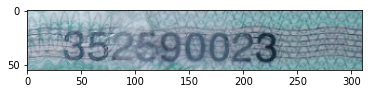

In [10]:
plt.imshow(img_warped[120:175, 390:700])

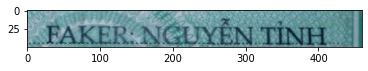

In [11]:
plt.imshow(img_warped[170:220,340:])

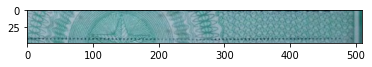

In [12]:
plt.imshow(img_warped[215:265,290:])

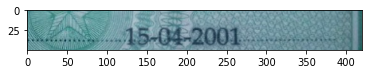

In [26]:
plt.imshow(img_warped[265:315,380:])

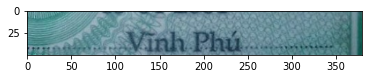

In [14]:
plt.imshow(img_warped[305:355, 420:])

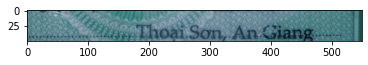

In [15]:
plt.imshow(img_warped[350:400, 250:])

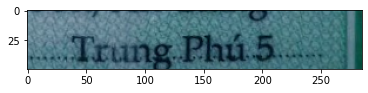

In [16]:
plt.imshow(img_warped[395:445, 515:])

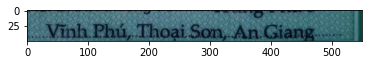

In [17]:
plt.imshow(img_warped[435:485, 250:])

The `vietocr` library also provides a pretrained model. However, because of the data used to train that model, it fails to return correct output for the cases where the first character in the image is far from the left side, or when the line is empty.

In [18]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
from PIL import Image

config = Cfg.load_config_from_name('vgg_transformer')
config['weights'] = './transformerocr.pth'
config['cnn']['pretrained']=False
config['device'] = 'cpu'
config['predictor']['beamsearch']=False

predictor = Predictor(config)

'352590023'

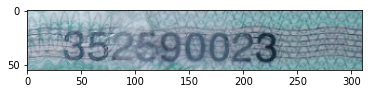

In [19]:
plt.imshow(img_warped[120:175, 390:700])
predictor.predict(Image.fromarray(img_warped[120:175, 390:700]))

'030100000002'

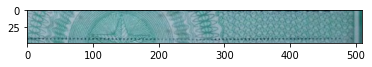

In [20]:
plt.imshow(img_warped[215:265,290:])
predictor.predict(Image.fromarray(img_warped[215:265,290:]))

'Hitanh Thoài Sơn, An Giang'

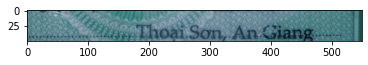

In [21]:
plt.imshow(img_warped[350:400, 250:])
predictor.predict(Image.fromarray(img_warped[350:400, 250:]))

One reason leading to this error is that the background in our images (the ID card) has much more texture than that used to train the `vietocr` pretrained model. Thus, we can train a new model specifically for text in ID cards. However, since it is impossible to get real data to train because the data is sensitive, we can synthesize the data from a template card, then use those data to train the model.

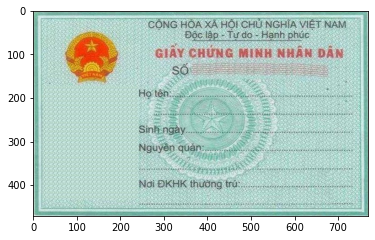

In [22]:
template = cv2.imread('data/template2.jpg')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
plt.imshow(template)

Next, we can use the `Pillow` library to write the text onto the image. It is important to choose the correct font and size for the text.

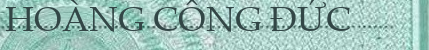

In [23]:
from PIL import Image, ImageDraw, ImageFont
img_syn = Image.fromarray(template[170:220,340:])
font = ImageFont.truetype('pala.ttf', size=35)
draw = ImageDraw.Draw(img_syn)
draw.text((5, 5), 'HOÀNG CÔNG ĐỨC', font=font, fill=(50, 70, 70))
img_syn

We can use a list of names and addresses to choose randomly to fill in the empty card, then add some augmentations by adjusting contrast, blurring, adding noise and geometrically transforming to create more data. Then, we can train the model with our dataset and use it to read the text.

After training the new model, we can use it to read the text from those regions. However, the model still gives incorrect predictions, partly because I only trained with synthetic data, which might be different from real data. In addition, the transformer part of the model learned a language model of Vietnamese names, so when trying with fake names, it may not give correct results

In [33]:
import frontside_model
import json
with open('frontside_reader.config', 'r') as f:
    config = json.load(f)
text_reader = frontside_model.Predictor(config['model'], 'frontside_reader.pth')

def get_text(img):
    new_h = 32
    h = img.shape[0]
    img = cv2.resize(img, (0, 0), fx=new_h/h, fy=new_h/h)
    img = img / 255
    return text_reader.predict(img)

352590023


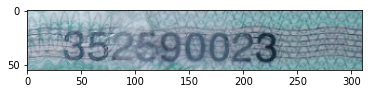

In [34]:
patch = img_warped[120:175, 390:700]
plt.imshow(patch)
print(get_text(patch))

EA KRRR'NGUYỄN TÍNH


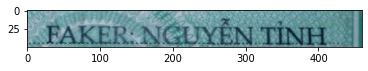

In [35]:
patch = img_warped[170:220,340:]
plt.imshow(patch)
print(get_text(patch))

15-04, 2001


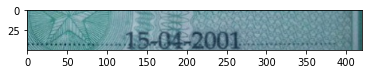

In [28]:
patch = img_warped[260:310,380:]
plt.imshow(patch)
print(get_text(patch))

Thoại Sơn, An Giang


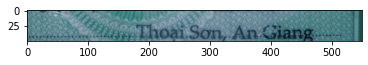

In [29]:
patch = img_warped[350:400,250:]
plt.imshow(patch)
print(get_text(patch))

# Backside

## Align the image

Similar to what we do to the frontside, here we will also follow the basic steps to extract information from the backside of the ID card. However, since the backside of an ID card is colored white, we cannot use the method applied for the frontside, as it is not reasonable to assume that the background in the image is not colored white.

An image of the backside ID card may look like this

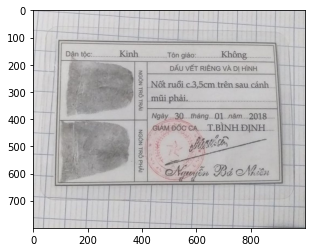

In [22]:
img = cv2.imread('data/template_back.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Thus, we cannot use color to segment the area containing the card. Directly looking for lines to indentify the edges will not work either, because there might be lines in the background, as well as lines inside the card.

To segment the card from the image in this problem, I use a deep neural network architecture named FCN (Fully Convolutional Network). Again, since there is no data available, I need to synthesize data for model training.

First, I start with a background image. I downloaded 1000 images from [unsplash](https://unsplash.com/) with *background* as search keyword.

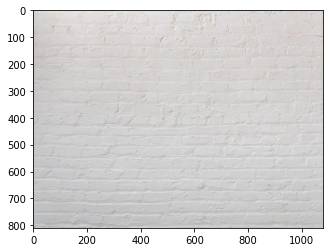

In [23]:
background = cv2.imread('background/6.jpeg')
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
plt.imshow(background)

Next, from an image of the ID card, I apply some augmentations to adjust its color and shape, then blend it to the background image. This gives both the image for model input as well as the mask of the region containing the card in the image to be used as label when training model.

In [24]:
from alignment_backside import *
dataset = SegmentationDataset('background', 'data/template_back2.jpeg', training=False)

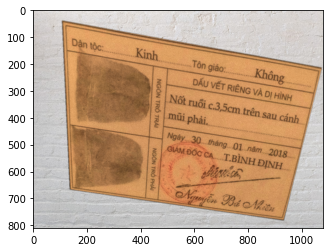

In [25]:
data = next(dataset)
plt.imshow(data['img'])

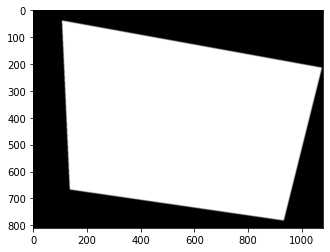

In [26]:
plt.imshow(data['mask'], cmap='gray')

Since the model is sensitive to the scale of the image, all training images are made so that the card consitutes a large part of the image. The model is only supposed to give good segmentations in those cases.

Similar to the algorithm for the frontside, the card in the image should only be rotated a small angle compared to the expected pose. Thus, the input images that the model can handle is a **landscape image with the card consituting most of the area**.

After training, we can load the model to segment new images. However, the masked produced by the model cannot match exactly the card in the image.

In [27]:
aligner = BacksideAligner()
aligner.load_weight('alignment_backside_weight.pth')

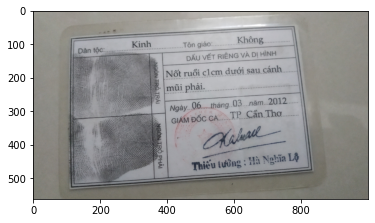

In [28]:
img = cv2.imread('data/test_backside4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
scale = 1000 / img.shape[1]
img = cv2.resize(img, (0, 0), fx=scale, fy=scale)
plt.imshow(img)

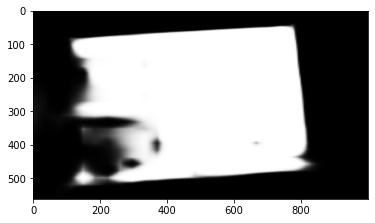

In [29]:
mask = aligner.segment(img)
plt.imshow(mask, cmap='gray')

The mask given by the model is an array of float numbers from 0 to 1 with the same size as the input image. The value at each position indicates the model's confidence that the corresponding pixel belongs to the foreground (the card). Some part, especially the fingerprint, may be incorectly segmented. We can correct this by using the grabcut algorithm to post-process the mask.

Grabcut is the algorithm usually used for foreground detection. It takes the image and an approximating mask as input, then used this information to find the actual foreground mask for the whole image. In the implementation in `opencv`, the values at each point in the input mask is one of the 4 values, including probable/definite foreground/backgroud.

To use this algorithm in our problem, I initiate the mask with the following rules:
- If the model mask gives value greater than 0.99, set the corresponding pixel as definite foreground
- If the model mask gives value between 0.5 and 0.99, set the corresponding pixel as probable foreground.
- Set all pixels whose distance to the closest edge of the image less than or equal 3 pixels to be definite background.
- Otherwise, set the pixels as probable background.

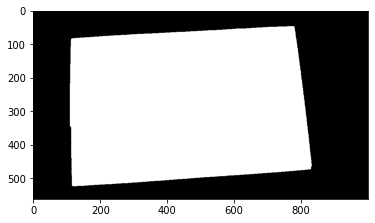

In [30]:
mask_refined = aligner.refine(img, mask)
plt.imshow(mask_refined, cmap='gray')

From this mask, we can proceed with the algorithm used for the frontside to get the image with ID card fitted exactly.

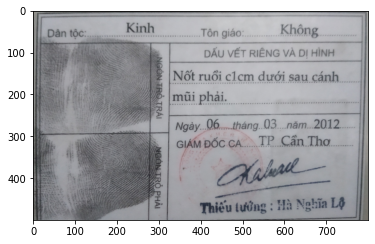

In [31]:
img_card = aligner.warp(img)
plt.imshow(img_card)

Now with this image, we can localize the area containing the texts then read them. Fortunately, since the background of the texts in this case is plain white, we can use the pretrained model provided by `vietocr` to read them.

In [32]:
def get_text(img_np):
    img_pil = Image.fromarray(img_np)
    return predictor.predict(img_pil)

Kinh


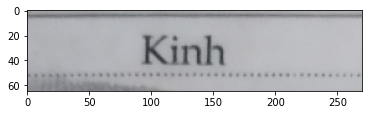

In [33]:
img_text = img_card[10:75, 130:400]
plt.imshow(img_text)
print(get_text(img_text))

Không


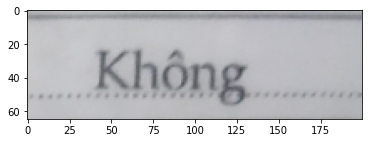

In [34]:
img_text = img_card[10:75, 550:750]
plt.imshow(img_text)
print(get_text(img_text))

Ngày 06. tháng.03 năm 2012


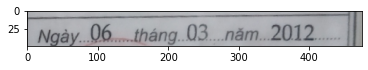

In [35]:
img_text = img_card[240:290, 325:]
plt.imshow(img_text)
print(get_text(img_text))

For date of issue, we will read the whole line instead of individual numbers for date, month, year. The aligned model may give results with slight offsets. For large text area, this will have a small effect but for small text area like those individual numbers, a small offset can lead to a large offset in region of interest. Therefore, we need to read the whole line to reduce.

The result from reading the line may be slightly incorrect, we can post-process it with regular expression.

In [36]:
import re
def parse_text(text):
    pattern = "[^\d]*(\d{1,2})[^\d]*(\d{1,2}).*?(\d+)"
    match = re.fullmatch(pattern, text)
    return match.group(1), match.group(2), match.group(3)

In [37]:
parse_text("Ngày 06. tháng.03 năm 2012")

('06', '03', '2012')